In [1]:

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb

import util
from util import inv_phi_range
from util import FWHM
from util import calculate_phi
import model as m

from tensorflow import keras
from tensorflow.keras import layers
from keras.engine import data_adapter

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from qkeras import QBatchNormalization
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning


/home/diptarko/.local/lib/python3.8/site-packages/hls4ml/converters/__init__.py:24: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [2]:
teacher_hidden_neurons = 256
student_hidden_neurons = 8
phi_div  = 64
eta_div  = 64
pt_div   = 64
qual_div = 64
k_reg          = kernel_regularizer=regularizers.l2(1e-4)
a_reg          = kernel_regularizer=regularizers.l2(1e-4)
ap_fixed       = [18, 5]

In [3]:
DATAPATH  = "/home/rardino/data/run3/"
MODELPATH = "./models/run3/"

if not os.path.exists(MODELPATH): os.makedirs(MODELPATH)

In [ ]:
df_base =util.load_data([
    os.path.join(DATAPATH,"run3golden_mm_singles.csv")
                 ])
df_base = util.apply_cut(df_base, 5.5, 45)
train_data, test_data, df_train, df_test = util.preprocess_data(df_base)
x_train, y_train = train_data
x_test, y_test = test_data
util.plot_data(df_base)

In [5]:
model = tf.keras.models.load_model('corrector-recalibration/best/')

2023-10-07 11:13:25.449147: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-07 11:13:26.627884: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10393 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2023-10-07 11:13:26.628955: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10407 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1


In [6]:
y_pred = model.predict(x_test, batch_size=2048)

y_pred = np.squeeze(y_pred)


delta_pt_pred =  y_pred[:] * pt_div * 0.5



pt_pred= np.array(df_test['PtL1Mu1'][:] - delta_pt_pred[:])


delta_pt_p = np.array(pt_pred - df_test['ptRecoMu1'][:])

2023-10-07 11:13:28.556973: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [7]:
bin_dist = 0.1
df_analysis = pd.DataFrame()
df_analysis["X"] = df_test["ptRecoMu1"]
df_analysis["NN"] = np.abs(delta_pt_p/df_test['ptRecoMu1'])
df_analysis["uGMT"] = np.abs(df_test['deltaPt1']/df_test['ptRecoMu1'])
df_analysis = df_analysis.sort_values(by=["X"])

In [8]:
X_bin = []
nn_bin = []
nn_bin_std = []
gmt_bin = []
gmt_bin_std = []

# dist = np.logspace(start=0,stop=df_analysis["X"].max(),num=100,base=1.03)
dist = np.arange(0,df_analysis["X"].max(),0.5)
for i in range(len(dist)):
    if i+1==len(dist):
        break
    X_bin.append(dist[i])
    idx = (df_analysis["X"]>dist[i]) * (df_analysis["X"]<(dist[i+1]))
    
    nn_ = df_analysis["NN"][idx]
    gmt = df_analysis["uGMT"][idx]
        
    nn_bin.append(nn_.mean())
    gmt_bin.append(gmt.mean())
    
    nn_bin_std.append(nn_.std()/np.sqrt(nn_.shape[0]))
    gmt_bin_std.append(gmt.std()/np.sqrt(gmt.shape[0]))

In [8]:
# x = X_bin
plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('axes', labelsize=32) 
# master = nn_bin
# masters = nn_bin_std

/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


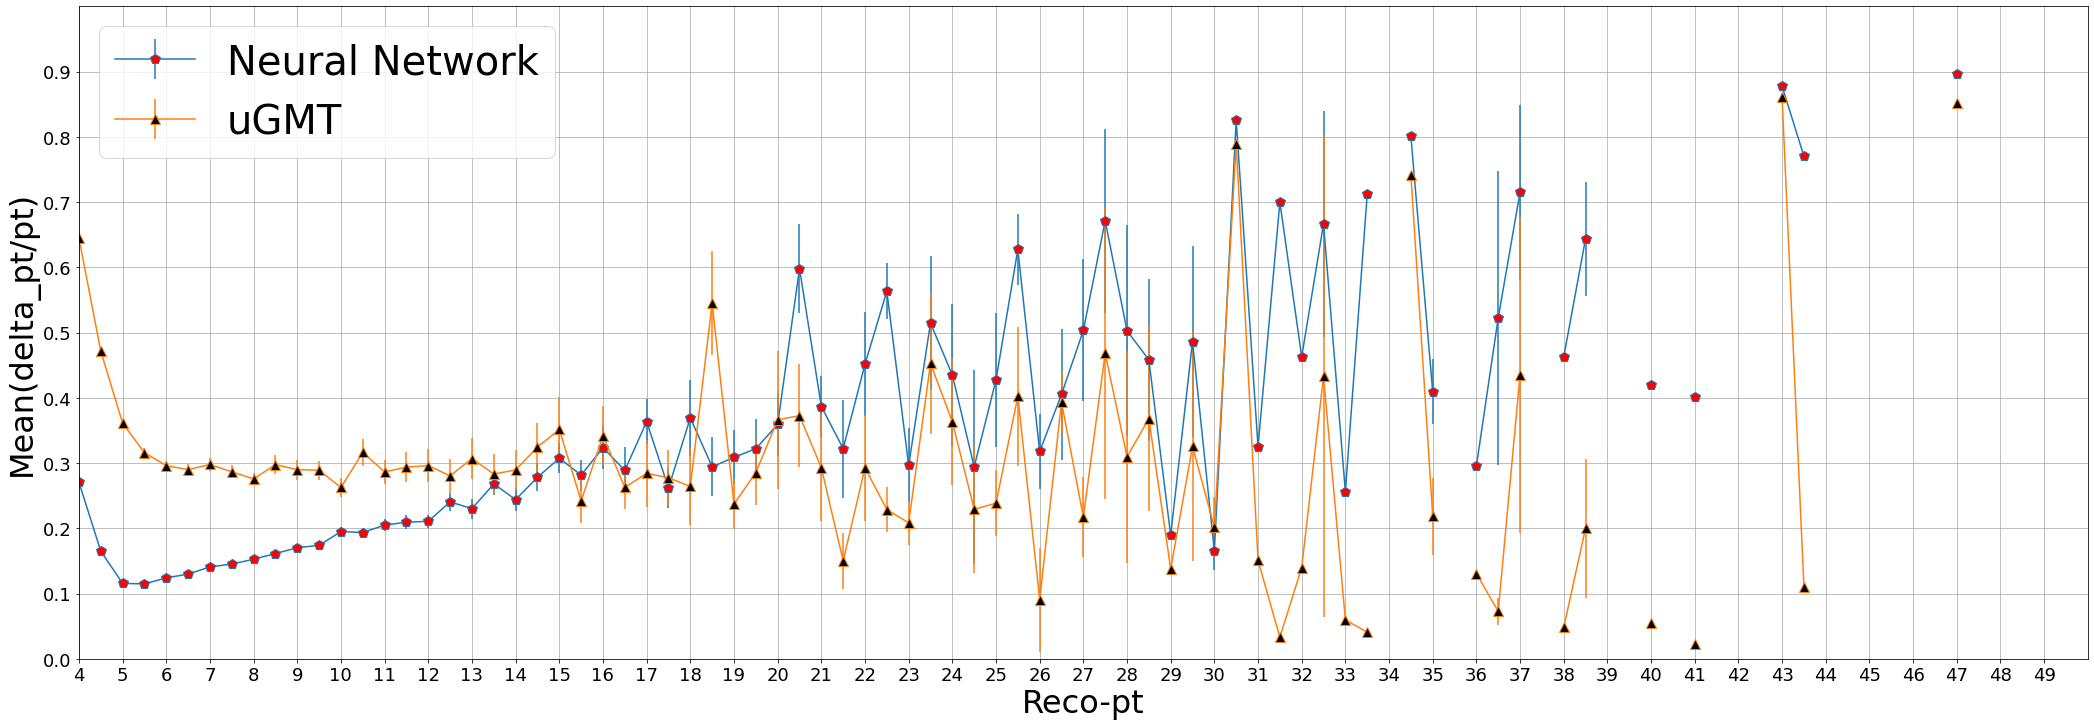

In [10]:
plt.figure(figsize=(36,12))
plt.errorbar(X_bin,nn_bin, nn_bin_std, label = "Neural Network",marker = "p",markersize=10,mfc ="red")
# plt.errorbar(X_bin,master, masters, label = "Master",marker = "p",markersize=10,mfc ="blue")
plt.errorbar(X_bin,gmt_bin,gmt_bin_std, label = "uGMT",marker = "^",markersize=10,mfc="black")
# plt.plot(X_bin,nn_bin)
# plt.plot(X_bin,gmt_bin)
plt.legend(fontsize="40")
plt.xticks(np.arange(0, 50, 1.0))
plt.yticks(np.arange(0, 1, 0.1))
plt.xlim(4,50)
plt.ylim(0,1)
plt.grid(True)
plt.xlabel("Reco-pt")
plt.ylabel("Mean(delta_pt/pt)")
plt.savefig("Reco.pdf")

In [11]:
bin_dist = 0.1
df_analysis = pd.DataFrame()
df_analysis["X"] = df_test["hwPtL1Mu1"]
df_analysis["NN"] = np.abs(delta_pt_p/df_test['ptRecoMu1'])
df_analysis["uGMT"] = np.abs(df_test['deltaPt1']/df_test['ptRecoMu1'])
df_analysis = df_analysis.sort_values(by=["X"])

In [12]:
X_bin = []
nn_bin = []
nn_bin_std = []
gmt_bin = []
gmt_bin_std = []

# dist = np.logspace(start=0,stop=df_analysis["X"].max(),num=100,base=1.03)
dist = np.arange(0,df_analysis["X"].max(),2)
for i in range(len(dist)):
    if i+1==len(dist):
        break
    X_bin.append(dist[i])
    idx = (df_analysis["X"]>dist[i]) * (df_analysis["X"]<(dist[i+1]))
    
    nn_ = df_analysis["NN"][idx]
    gmt = df_analysis["uGMT"][idx]
        
    nn_bin.append(nn_.mean())
    gmt_bin.append(gmt.mean())
    
    nn_bin_std.append(nn_.std()/np.sqrt(nn_.shape[0]))
    gmt_bin_std.append(gmt.std()/np.sqrt(gmt.shape[0]))

/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


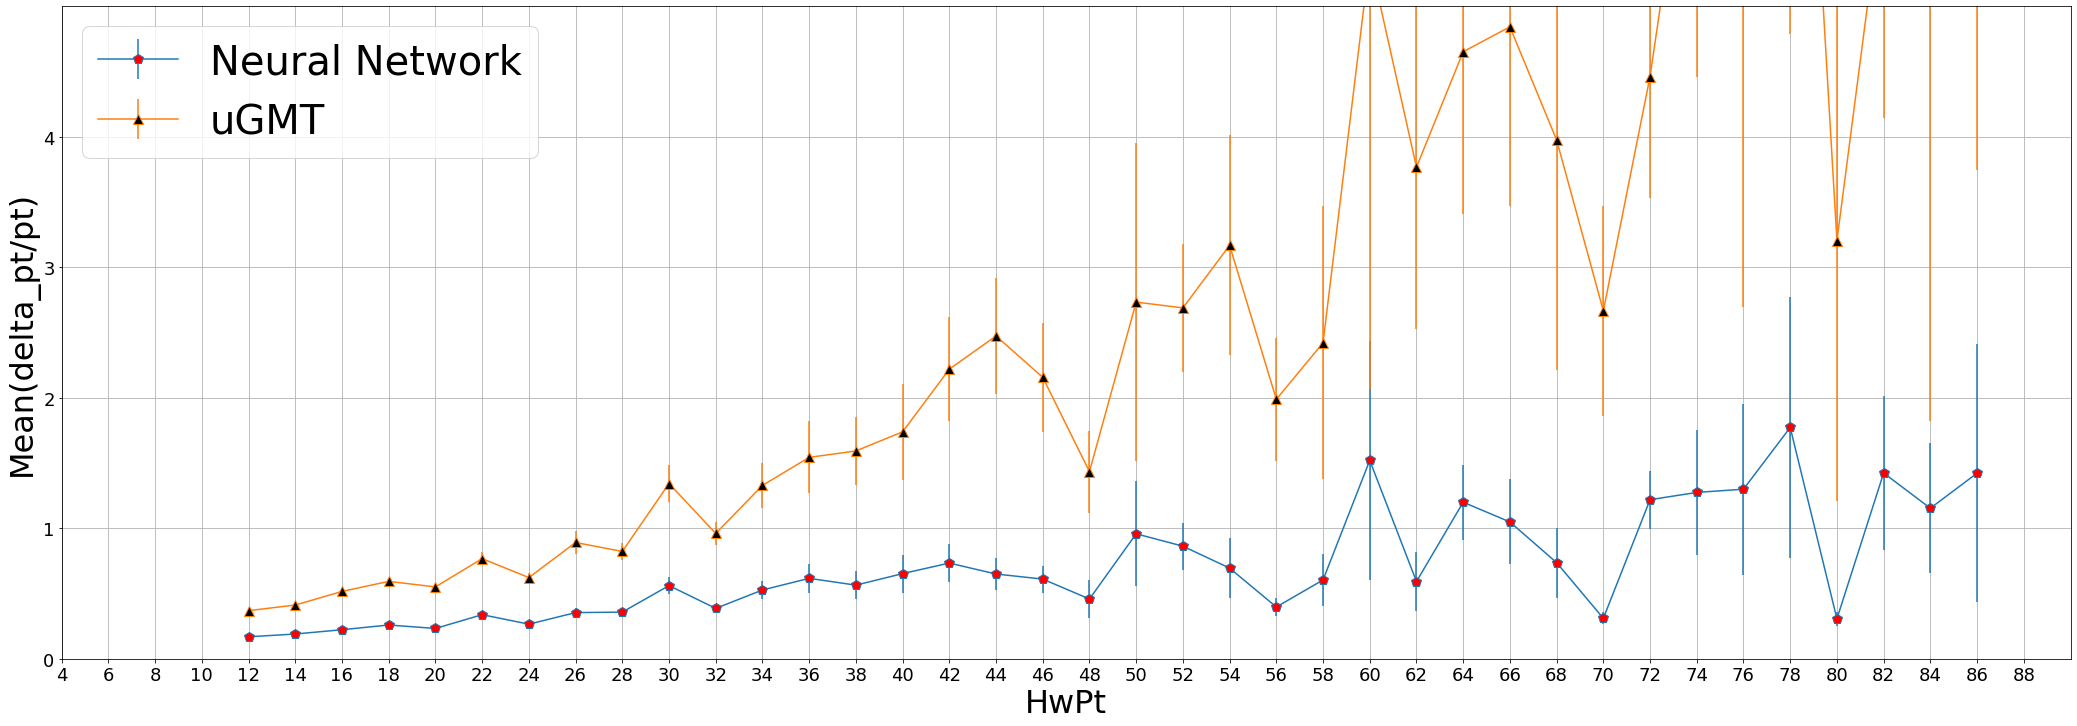

In [13]:
plt.figure(figsize=(36,12))
plt.errorbar(X_bin,nn_bin, nn_bin_std, label = "Neural Network",marker = "p",markersize=10,mfc ="red")
# plt.errorbar(X_bin,master, masters, label = "Master",marker = "p",markersize=10,mfc ="blue")
plt.errorbar(X_bin,gmt_bin,gmt_bin_std, label = "uGMT",marker = "^",markersize=10,mfc="black")
# plt.plot(X_bin,nn_bin)
# plt.plot(X_bin,gmt_bin)
plt.legend()
plt.xticks(np.arange(0, 90, 2))
plt.yticks(np.arange(0, 5, 1))
plt.xlim(4,90)
plt.ylim(0,5)
plt.grid(True)
plt.legend(fontsize="40")
plt.xlabel("HwPt")
plt.ylabel("Mean(delta_pt/pt)")
plt.savefig("Hardware.pdf")

/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


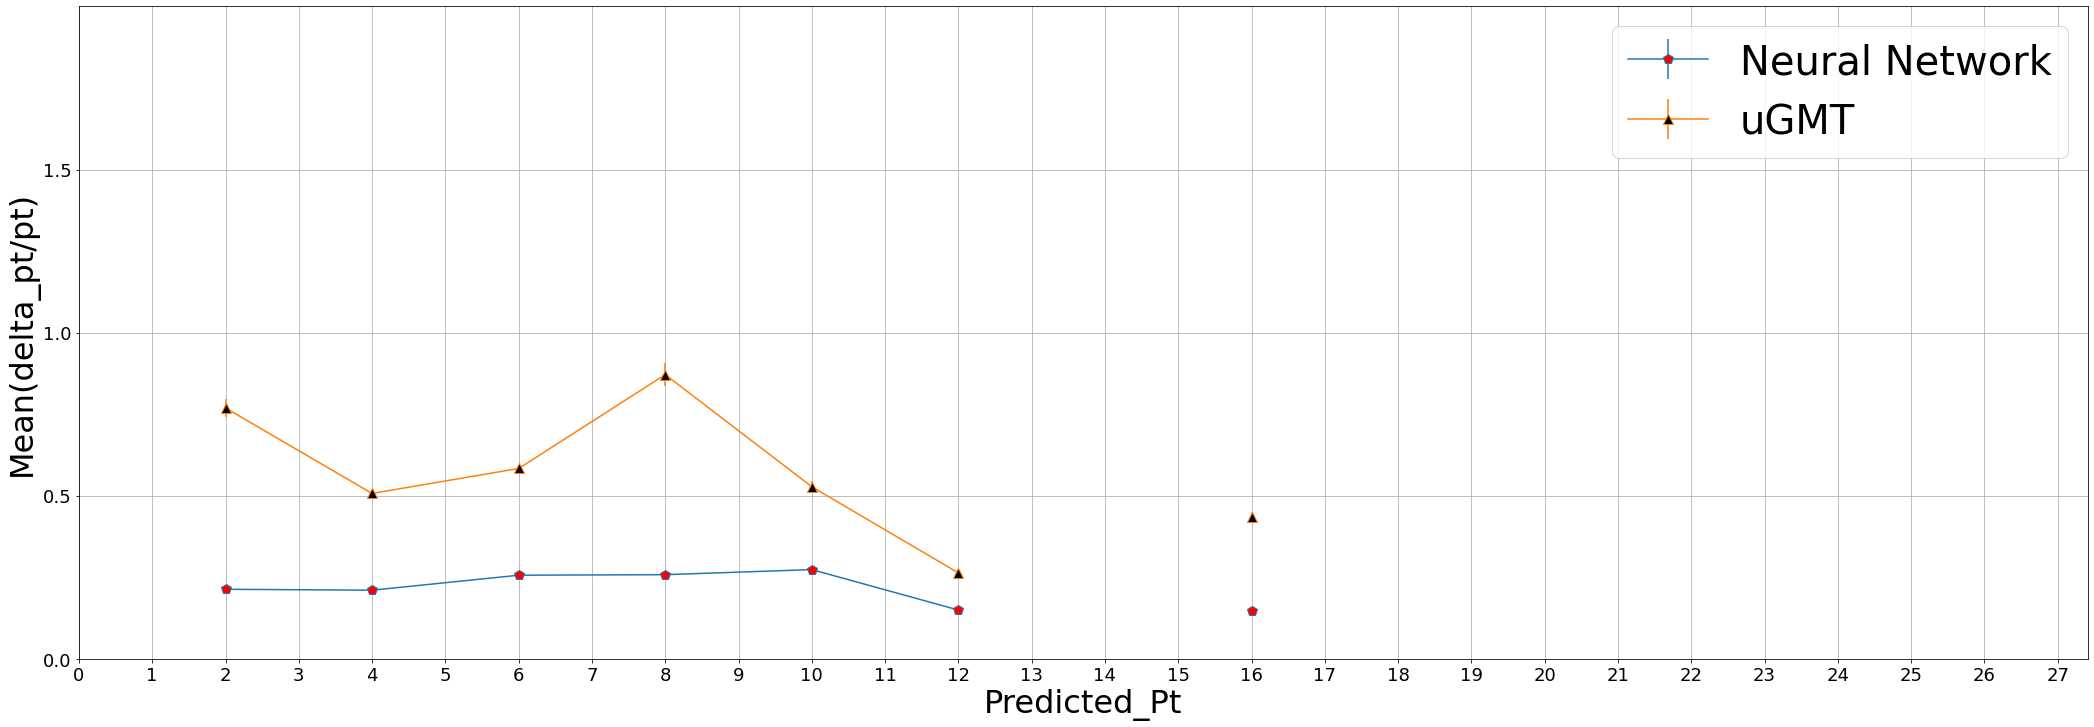

In [14]:
bin_dist = 0.1
df_analysis = pd.DataFrame()
df_analysis["X"] = pt_pred
df_analysis["NN"] = np.abs(delta_pt_p/df_test['ptRecoMu1'])
df_analysis["uGMT"] = np.abs(df_test['deltaPt1']/df_test['ptRecoMu1'])
df_analysis = df_analysis.sort_values(by=["X"])

X_bin = []
nn_bin = []
nn_bin_std = []
gmt_bin = []
gmt_bin_std = []

# dist = np.logspace(start=0,stop=df_analysis["X"].max(),num=100,base=1.03)
dist = np.arange(0,df_analysis["X"].max(),2)
for i in range(len(dist)):
    if i+1==len(dist):
        break
    X_bin.append(dist[i])
    idx = (df_analysis["X"]>dist[i]) * (df_analysis["X"]<(dist[i+1]))
    
    nn_ = df_analysis["NN"][idx]
    gmt = df_analysis["uGMT"][idx]
        
    nn_bin.append(nn_.mean())
    gmt_bin.append(gmt.mean())
    
    nn_bin_std.append(nn_.std()/np.sqrt(nn_.shape[0]))
    gmt_bin_std.append(gmt.std()/np.sqrt(gmt.shape[0]))

    
plt.figure(figsize=(36,12))
plt.errorbar(X_bin,nn_bin, nn_bin_std, label = "Neural Network",marker = "p",markersize=10,mfc ="red")
# plt.errorbar(X_bin,master, masters, label = "Master",marker = "p",markersize=10,mfc ="blue")
plt.errorbar(X_bin,gmt_bin,gmt_bin_std, label = "uGMT",marker = "^",markersize=10,mfc="black")
# plt.plot(X_bin,nn_bin)
# plt.plot(X_bin,gmt_bin)
plt.legend()
plt.xticks(np.arange(0, df_analysis["X"].max(), 1))
plt.yticks(np.arange(0, 2, 0.5))
plt.xlim(0, df_analysis["X"].max())
plt.ylim(0,2)
plt.grid(True)
plt.legend(fontsize="40")
plt.xlabel("Predicted_Pt")
plt.ylabel("Mean(delta_pt/pt)")
plt.savefig("Predicted_pt.pdf")

/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


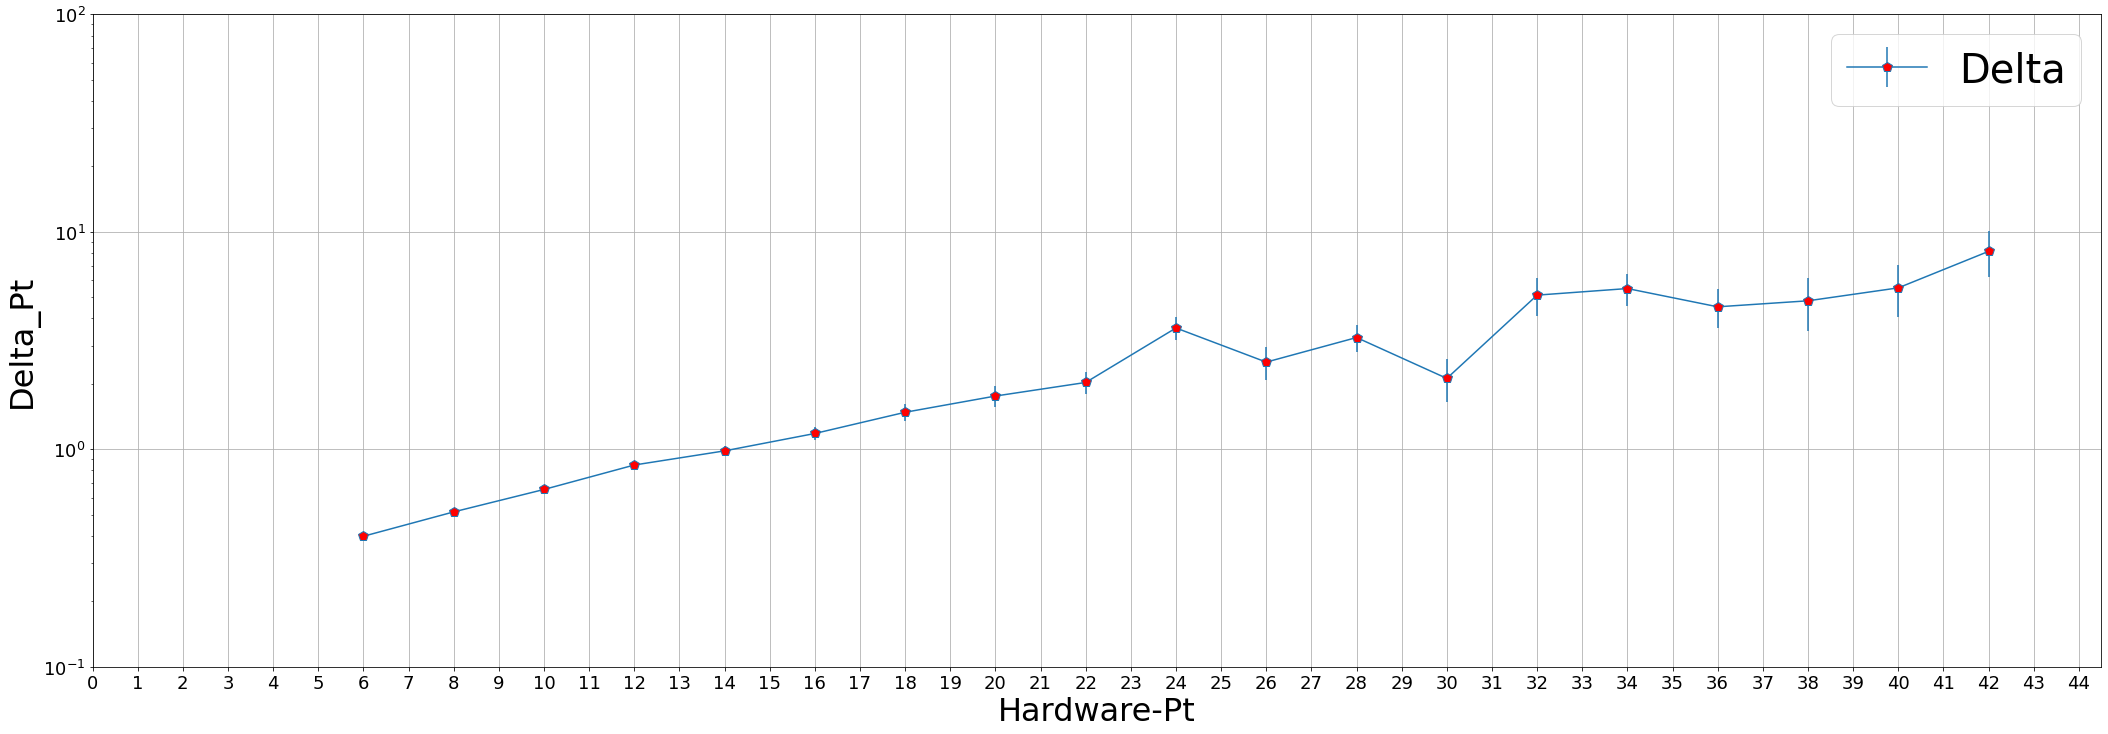

In [10]:
bin_dist = 0.1
df_analysis = pd.DataFrame()
df_analysis["X"] = df_test['PtL1Mu1']
df_analysis["Delta_Pt"] = np.abs((df_test['ptRecoMu1']-df_test['PtL1Mu1'])/df_test['ptRecoMu1'])
df_analysis = df_analysis.sort_values(by=["X"])

X_bin = []
Y_bin = []
Y_bin_std = []

# dist = np.logspace(start=0,stop=df_analysis["X"].max(),num=100,base=1.03)
dist = np.arange(0,df_analysis["X"].max(),2)
for i in range(len(dist)):
    if i+1==len(dist):
        break
    X_bin.append(dist[i])
    idx = (df_analysis["X"]>dist[i]) * (df_analysis["X"]<(dist[i+1]))
    
    y_ = df_analysis["Delta_Pt"][idx]
        
    Y_bin.append(y_.mean())
    
    Y_bin_std.append(y_.std()/np.sqrt(y_.shape[0]))

    
plt.figure(figsize=(36,12))
plt.errorbar(X_bin,Y_bin, Y_bin_std, label = "Delta",marker = "p",markersize=10,mfc ="red")
# plt.errorbar(X_bin,master, masters, label = "Master",marker = "p",markersize=10,mfc ="blue")
# plt.errorbar(X_bin,gmt_bin,gmt_bin_std, label = "uGMT",marker = "^",markersize=10,mfc="black")
# plt.plot(X_bin,nn_bin)
# plt.plot(X_bin,gmt_bin)
plt.legend()
plt.xticks(np.arange(0, df_analysis["X"].max(), 1))
plt.yticks([0,1,10,50,100,500,1000])
plt.xlim(0, df_analysis["X"].max())
plt.ylim(0.1,100)
plt.grid(True)
plt.yscale("log")
plt.legend(fontsize="40")
plt.xlabel("Hardware-Pt")
plt.ylabel("Delta_Pt")
plt.savefig("hardware_vs_delta.pdf")

/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


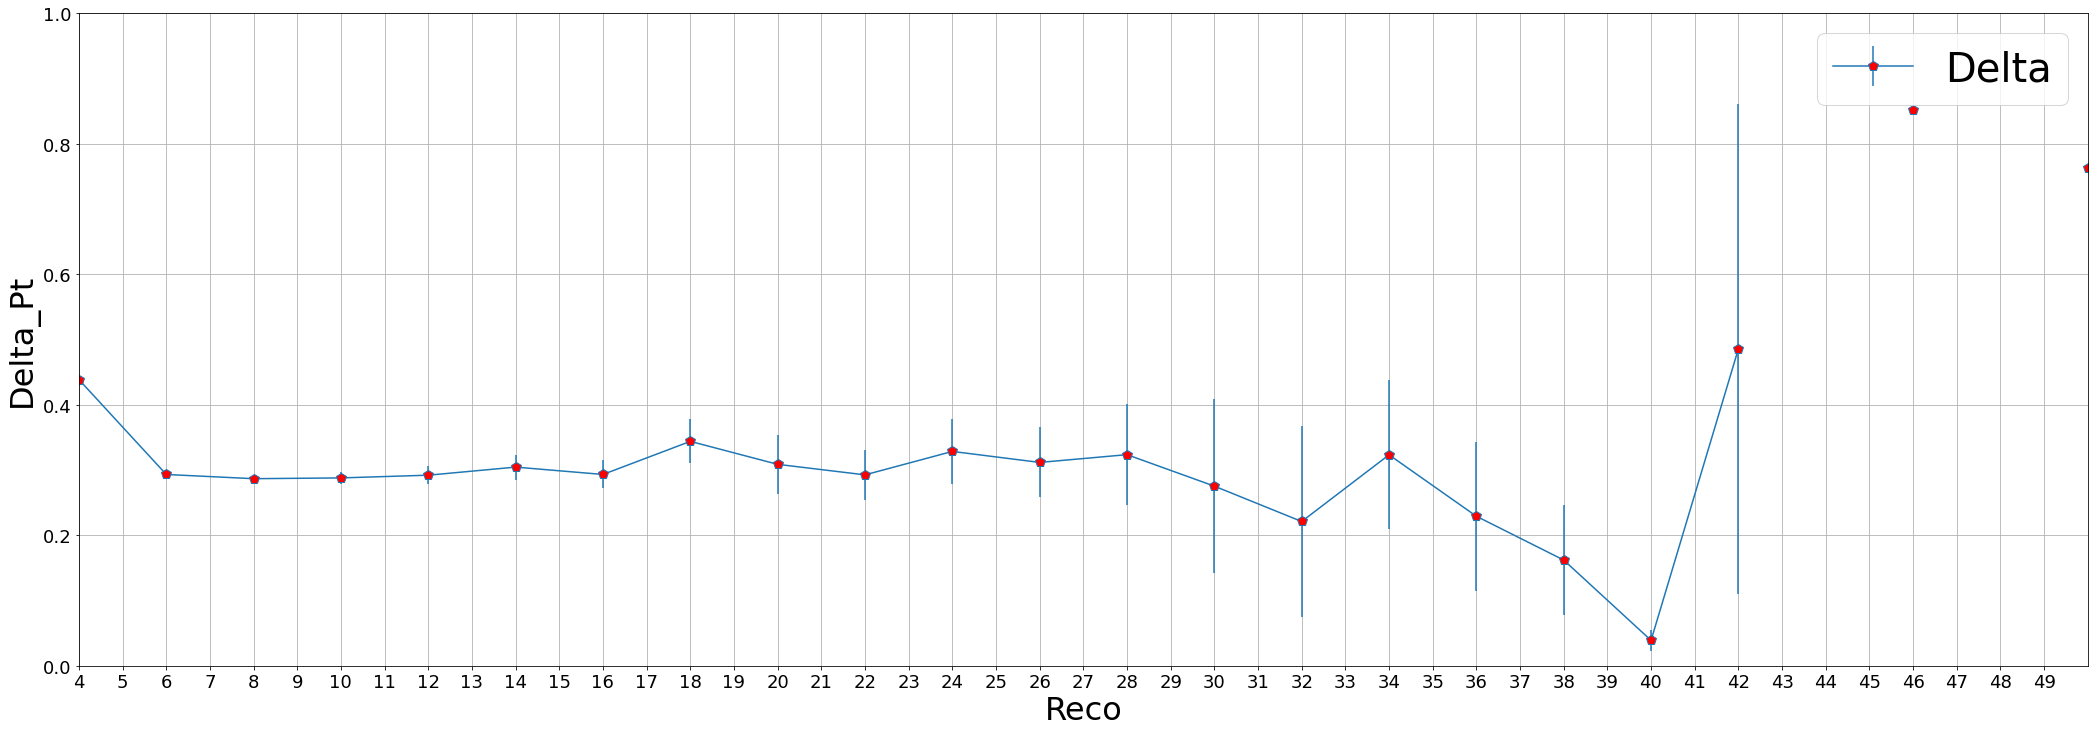

In [19]:
bin_dist = 0.1
df_analysis = pd.DataFrame()
df_analysis["X"] = df_test['ptRecoMu1']
df_analysis["Delta_Pt"] = np.abs((df_test['ptRecoMu1']-df_test['PtL1Mu1'])/df_test['ptRecoMu1'])
df_analysis = df_analysis.sort_values(by=["X"])

X_bin = []
Y_bin = []
Y_bin_std = []

# dist = np.logspace(start=0,stop=df_analysis["X"].max(),num=100,base=1.03)
dist = np.arange(0,df_analysis["X"].max(),2)
for i in range(len(dist)):
    if i+1==len(dist):
        break
    X_bin.append(dist[i])
    idx = (df_analysis["X"]>dist[i]) * (df_analysis["X"]<(dist[i+1]))
    
    y_ = df_analysis["Delta_Pt"][idx]
        
    Y_bin.append(y_.mean())
    
    Y_bin_std.append(y_.std()/np.sqrt(y_.shape[0]))

    
plt.figure(figsize=(36,12))
plt.errorbar(X_bin,Y_bin, Y_bin_std, label = "Delta",marker = "p",markersize=10,mfc ="red")
# plt.errorbar(X_bin,master, masters, label = "Master",marker = "p",markersize=10,mfc ="blue")
# plt.errorbar(X_bin,gmt_bin,gmt_bin_std, label = "uGMT",marker = "^",markersize=10,mfc="black")
# plt.plot(X_bin,nn_bin)
# plt.plot(X_bin,gmt_bin)
plt.legend()
plt.xticks(np.arange(0, 50, 1.0))
# plt.yticks([0,1,10,50,100,500,1000])
plt.xlim(4,50)
plt.ylim(0,1)
plt.grid(True)
# plt.yscale("log")
plt.legend(fontsize="40")
plt.xlabel("Reco")
plt.ylabel("Delta_Pt")
plt.savefig("delta_reco.pdf")

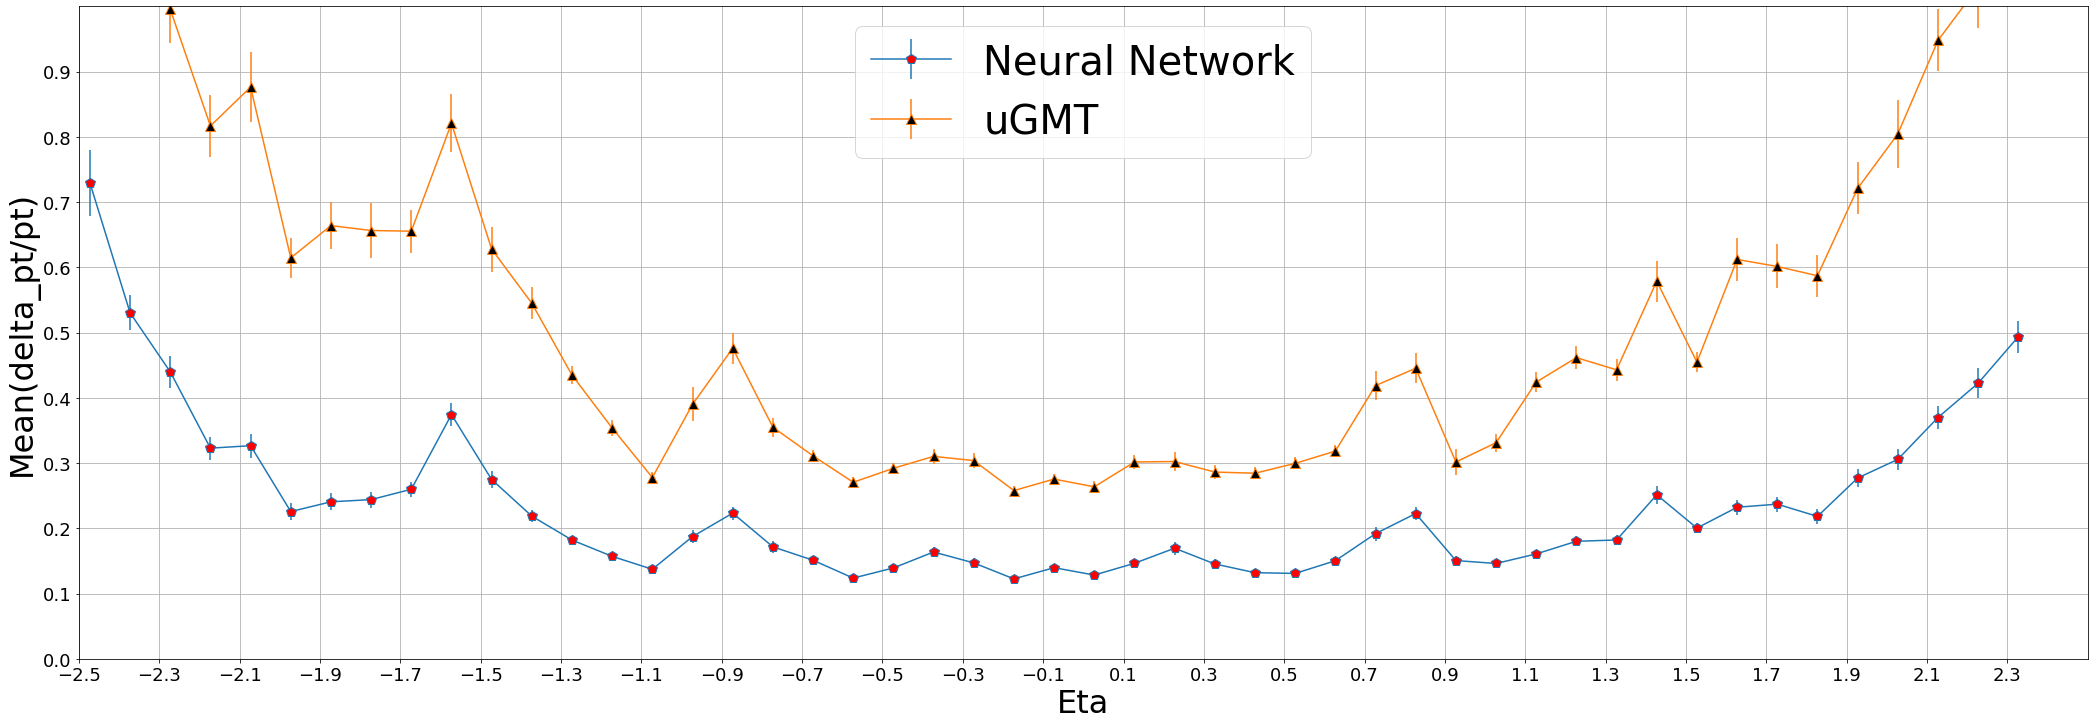

In [8]:
bin_dist = 0.1
df_analysis = pd.DataFrame()
df_analysis["X"] = df_test["etaExtRecoSt2Mu1"]
df_analysis["NN"] = np.abs(delta_pt_p/df_test['ptRecoMu1'])
df_analysis["uGMT"] = np.abs(df_test['deltaPt1']/df_test['ptRecoMu1'])
df_analysis = df_analysis.sort_values(by=["X"])



X_bin = []
nn_bin = []
nn_bin_std = []
gmt_bin = []
gmt_bin_std = []

# dist = np.logspace(start=0,stop=df_analysis["X"].max(),num=100,base=1.03)
dist = np.arange(df_analysis["X"].min(),df_analysis["X"].max(),0.1)
for i in range(len(dist)):
    if i+1==len(dist):
        break
    X_bin.append(dist[i])
    idx = (df_analysis["X"]>dist[i]) * (df_analysis["X"]<(dist[i+1]))
    
    nn_ = df_analysis["NN"][idx]
    gmt = df_analysis["uGMT"][idx]
        
    nn_bin.append(nn_.mean())
    gmt_bin.append(gmt.mean())
    
    nn_bin_std.append(nn_.std()/np.sqrt(nn_.shape[0]))
    gmt_bin_std.append(gmt.std()/np.sqrt(gmt.shape[0]))
    

    
# x = X_bin
plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('axes', labelsize=32) 
# mastaer = nn_bin
# masters = nn_bin_std


plt.figure(figsize=(36,12))
plt.errorbar(X_bin,nn_bin, nn_bin_std, label = "Neural Network",marker = "p",markersize=10,mfc ="red")
# plt.errorbar(X_bin,master, masters, label = "Master",marker = "p",markersize=10,mfc ="blue")
plt.errorbar(X_bin,gmt_bin,gmt_bin_std, label = "uGMT",marker = "^",markersize=10,mfc="black")
# plt.plot(X_bin,nn_bin)
# plt.plot(X_bin,gmt_bin)
plt.legend(fontsize="40")
plt.xticks(np.arange(-2.5, 2.5, 0.2))
plt.yticks(np.arange(0, 1, 0.1))
plt.xlim(-2.5,2.5)
plt.ylim(0,1)
plt.grid(True)
plt.xlabel("Eta")
plt.ylabel("Mean(delta_pt/pt)")
plt.savefig("reso_eta.pdf")

In [9]:
df_analysis = pd.DataFrame()
df_analysis["X"] = df_test["ptRecoMu1"]
df_analysis["Y"] = df_test["etaExtRecoSt2Mu1"]
df_analysis["NN"] = np.abs(delta_pt_p/df_test['ptRecoMu1'])
df_analysis["uGMT"] = np.abs(df_test['deltaPt1']/df_test['ptRecoMu1'])



# df_analysis = df_analysis.sort_values(by=["X"])
X_bin = []
Y_bin = []

nn_bin = []
nn_bin_std = []

gmt_bin = []
gmt_bin_std = []

dist_y = np.arange(df_analysis["Y"].min(),df_analysis["Y"].max(),0.1)
dist_x = np.arange(4,45,1)

#x
XY_bin = []
for i in range(len(dist_x)):
    if i+1==len(dist_x):
        break
    X_bin_ = []
    Y_bin_ = []
    nn_bin_ = []
    gmt_bin_ = []
    for j in range(len(dist_y)):
        if j+1==len(dist_y):
            break
        X_bin_.append(dist_x[i])
        Y_bin_.append(dist_y[j])
        idx = (df_analysis["X"]>dist_x[i]) * (df_analysis["X"]<(dist_x[i+1])) * (df_analysis["Y"]>dist_y[j]) * (df_analysis["Y"]<(dist_y[j+1]))
        
        nn_ = df_analysis["NN"][idx]
        gmt = df_analysis["uGMT"][idx]
        
        nn_bin_.append(nn_.mean())
        gmt_bin_.append(gmt.mean())
    nn_bin.append(nn_bin_)
    gmt_bin.append(gmt_bin_)
    X_bin.append(X_bin_)
    Y_bin.append(Y_bin_)

In [33]:
plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('axes', labelsize=25) 

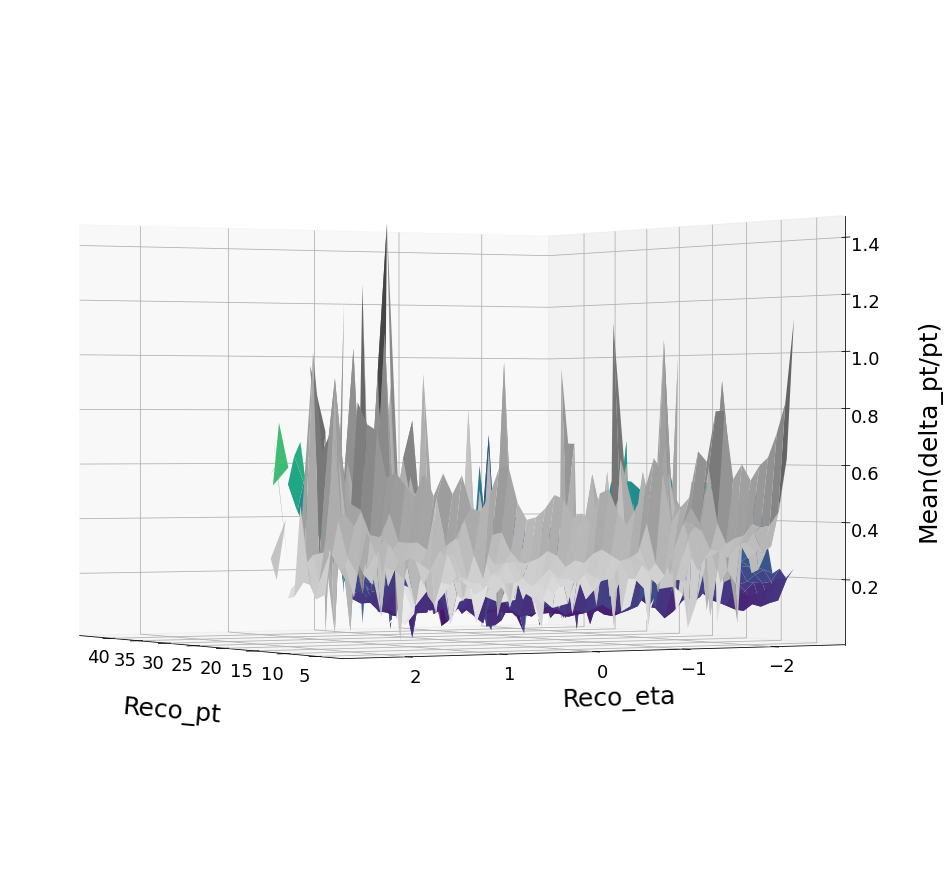

In [85]:
from mpl_toolkits import mplot3d
%matplotlib inline
fig = plt.figure(figsize=(16,16))
ax = plt.axes(projection='3d')

ax = plt.axes(projection='3d')
ax.plot_surface(np.array(X_bin), np.array(Y_bin), np.array(nn_bin), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.plot_surface(np.array(X_bin), np.array(Y_bin), np.array(gmt_bin), rstride=1, cstride=1,
                cmap='gray_r', edgecolor='none')


ax.azim = 150
ax.dist = 10
ax.elev = 0

ax.set_xlabel('\nReco_pt', linespacing=4)
ax.set_ylabel("\nReco_eta",linespacing=2)
ax.set_zlabel("\nMean(delta_pt/pt)",linespacing=4)
# ax.set_zticks([])
plt.savefig("3d_view3.pdf")

In [11]:
# Import dependencies
import plotly
import plotly.graph_objs as go

# Configure Plotly to be rendered inline in the notebook.




fig = go.Figure(data=[
    go.Surface(x=np.array(X_bin), y=np.array(Y_bin), z=np.array(nn_bin),colorscale ='oranges',showscale=False),
    go.Surface(go.Surface(x=np.array(X_bin), y=np.array(Y_bin), z=np.array(gmt_bin),colorscale ='gray'),showscale=False)

])

fig.update_layout(autosize = False,
                  width=1000, height=1000)


fig.show()

In [12]:
df_analysis = pd.DataFrame()
df_analysis["X"] = df_test["ptRecoMu1"]
df_analysis["Y"] = df_test["etaExtRecoSt2Mu1"]
df_analysis["NN"] = np.abs(delta_pt_p/df_test['ptRecoMu1'])
df_analysis["uGMT"] = np.abs(df_test['deltaPt1']/df_test['ptRecoMu1'])
# df_analysis = df_analysis.sort_values(by=["X"])
X_bin = []
Y_bin = []

nn_bin = []
nn_bin_std = []

gmt_bin = []
gmt_bin_std = []

dist_y = np.arange(df_analysis["Y"].min(),df_analysis["Y"].max(),0.1)
dist_x = np.arange(4,45,1)

#x
XY_bin = []
for i in range(len(dist_x)):
    if i+1==len(dist_x):
        break
    X_bin_ = []
    Y_bin_ = []
    nn_bin_ = []
    gmt_bin_ = []
    for j in range(len(dist_y)):
        if j+1==len(dist_y):
            break
        X_bin_.append(dist_x[i])
        Y_bin_.append(dist_y[j])
        idx = (df_analysis["X"]>dist_x[i]) * (df_analysis["X"]<(dist_x[i+1])) * (df_analysis["Y"]>dist_y[j]) * (df_analysis["Y"]<(dist_y[j+1]))
        
        nn_ = df_analysis["NN"][idx]
        gmt = df_analysis["uGMT"][idx]
        
        nn_bin_.append(nn_.mean())
        gmt_bin_.append(gmt.mean())
    nn_bin.append(nn_bin_)
    gmt_bin.append(gmt_bin_)
    X_bin.append(X_bin_)
    Y_bin.append(Y_bin_)

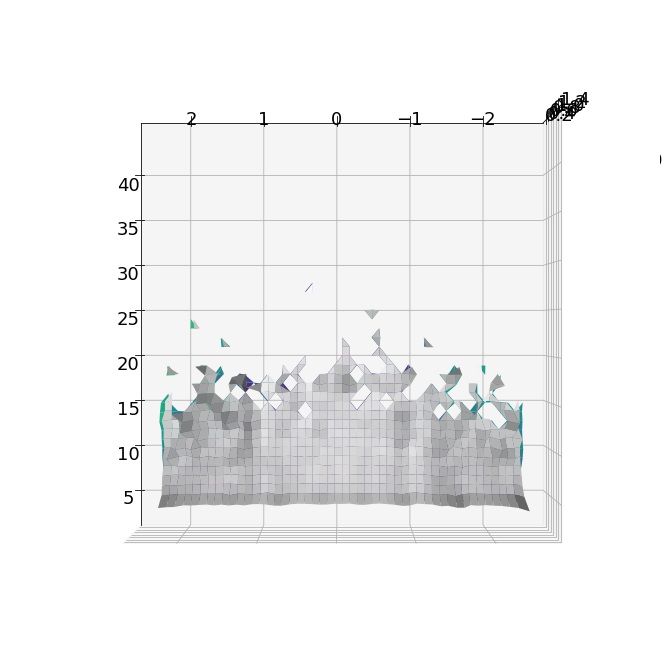

In [13]:
from mpl_toolkits import mplot3d
%matplotlib inline
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')

ax = plt.axes(projection='3d')
ax.plot_surface(np.array(X_bin), np.array(Y_bin), np.array(nn_bin), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.plot_surface(np.array(X_bin), np.array(Y_bin), np.array(gmt_bin), rstride=1, cstride=1,
                cmap='gray_r', edgecolor='none')


ax.azim = 180
ax.dist = 10
ax.elev = 90